In [1]:
# !pip install pytorchvideo transformers evaluate -q
# !pip install accelerate -U
# !pip install torchvision==0.16.0
# !pip install pytorchvideo
# !pip install ipywidgets


In [2]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

c:\Users\antoi\Documents\Work_Learn\JEDHA\.venv\Lib\site-packages\torchvision\transforms\functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [3]:
from torchvision.transforms import Compose, Lambda, RandomCrop, RandomHorizontalFlip, Resize
from pytorchvideo.transforms import UniformTemporalSubsample, Normalize, RandomShortSideScale, ApplyTransformToKey
from transformers import TrainingArguments, Trainer
from datasets import load_metric
import torch
import os
import pathlib

dataset_root_path = "data-label"
dataset_root_path = pathlib.Path(dataset_root_path)
print(dataset_root_path)

video_count_train = len(list(dataset_root_path.glob("train/*/*.mp4")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.mp4")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.mp4")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.mp4"))
    + list(dataset_root_path.glob("val/*/*.mp4"))
    + list(dataset_root_path.glob("test/*/*.mp4"))
)

print(all_video_file_paths[:5])

# print({os.path.basename(path) for path in all_video_file_paths})

# class_labels = sorted({os.path.basename(path) for path in all_video_file_paths})
class_labels = sorted({str(path).split("\\")[2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

data-label
Total videos: 273
[WindowsPath('data-label/train/cutback-frontside/video_1.mp4'), WindowsPath('data-label/train/cutback-frontside/video_10.mp4'), WindowsPath('data-label/train/cutback-frontside/video_11.mp4'), WindowsPath('data-label/train/cutback-frontside/video_12.mp4'), WindowsPath('data-label/train/cutback-frontside/video_13.mp4')]
Unique classes: ['cutback-frontside', 'roller'].


In [5]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification,VideoMAEConfig
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 4 # batch size for training and evaluation


# Now, use this configuration when initializing your model
model_ckpt = "MCG-NJU/videomae-base"  # pre-trained model from which to fine-tune
batch_size = 4  # batch size for training and evaluation

image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'fc_norm.bias', 'fc_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

# Example values for variables
num_frames_to_sample = 16
sample_rate = 4
fps = 25

# Example code snippet
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    print('same')
    height = width = image_processor.size["shortest_edge"]
else:
    print('different')
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

clip_duration = num_frames_to_sample * sample_rate / fps



same


In [ ]:
# Set Training Configuration
args = TrainingArguments(
    "fine-tuned-model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    # push_to_hub=True,
)


c:\Users\antoi\Documents\Work_Learn\JEDHA\.venv\Lib\site-packages\datasets\load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
# Define Evaluation Metric
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions.argmax(axis=1)
    references = eval_pred.label_ids
    return metric.compute(predictions=predictions, references=references)

# Define Collate Function
def collate_fn(examples):
    pixel_values = torch.stack([example["video"].permute(1, 0, 2, 3) for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


In [ ]:
import os

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 16
sample_rate = 32
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps


# Training dataset transfor mations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    # RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    # RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [ ]:
# Initialize a counter
dataset_size = 0

# Iterate through the dataset and count the number of samples
for _ in train_dataset:
    dataset_size += 1

print("Training dataset size:", dataset_size)


Training dataset size: 149


In [ ]:
clip_duration

17.066666666666666

In [ ]:
tot = train_dataset.num_videos + val_dataset.num_videos + test_dataset.num_videos
train = train_dataset.num_videos/tot*100
val =val_dataset.num_videos/tot*100
test =test_dataset.num_videos/tot*100

print(f'tot:{tot}')
print(f'train: {train:.2f}%\n')
print(f'test: {test:.2f}%\n')
print(f'val: {val:.2f}%\n')


tot:273
train: 54.58%

test: 25.27%

val: 20.15%



In [ ]:
# Create an iterator for the dataset
train_iterator = iter(train_dataset)
for _ in range(9):
    next(train_iterator)
tenth_video = next(train_iterator)
tenth_video

{'video': tensor([[[[ 0.7591,  0.7591,  0.7591,  ...,  0.7762,  0.7762,  0.7762],
           [ 0.7591,  0.7591,  0.7591,  ...,  0.7762,  0.7762,  0.7762],
           [ 0.7591,  0.7591,  0.7591,  ...,  0.7933,  0.7933,  0.7933],
           ...,
           [-0.3369, -0.3369, -0.3027,  ...,  0.2282,  0.2282,  0.2624],
           [-0.1657, -0.1657, -0.1657,  ...,  0.2624,  0.2624,  0.2624],
           [-0.1143, -0.0629, -0.0629,  ...,  0.2282,  0.2453,  0.2796]],
 
          [[ 0.7591,  0.7591,  0.7591,  ...,  0.5707,  0.6392,  0.6734],
           [ 0.7591,  0.7591,  0.7591,  ...,  0.1768,  0.2453,  0.3823],
           [ 0.7591,  0.7591,  0.7591,  ..., -0.2342, -0.2513, -0.1486],
           ...,
           [-0.3883, -0.4054, -0.3883,  ...,  0.0569,  0.1597,  0.1254],
           [-0.5767, -0.5424, -0.5424,  ..., -0.1143, -0.0801, -0.1143],
           [-0.4226, -0.3883, -0.3712,  ..., -0.2171, -0.2171, -0.2171]],
 
          [[ 0.7591,  0.7591,  0.7591,  ...,  0.6392,  0.4166,  0.4851],
    

In [ ]:
sample_video = next(iter(train_dataset))
# print(sample_video)
sample_video.keys()

{'video': tensor([[[[-0.3541,  0.2796, -0.0629,  ..., -0.5767, -0.5767, -0.5767],
          [-0.3027,  0.2624, -0.0629,  ..., -0.5767, -0.5596, -0.5767],
          [-0.4054, -0.4739, -0.4226,  ..., -0.5767, -0.5596, -0.5596],
          ...,
          [-0.4397, -0.4397, -0.4568,  ...,  1.1187,  1.1529,  1.1700],
          [-0.4568, -0.4568, -0.5596,  ...,  1.1187,  1.1529,  1.1700],
          [-0.5596, -0.5596, -0.6794,  ...,  1.1187,  1.1700,  1.1872]],

         [[-0.6452, -0.6452, -0.6452,  ..., -0.5938, -0.5938, -0.5938],
          [-0.6452, -0.6452, -0.6965,  ..., -0.5767, -0.5767, -0.5938],
          [-0.6452, -0.6452, -0.6623,  ..., -0.5767, -0.5596, -0.5767],
          ...,
          [-0.6794, -0.7479, -0.6965,  ...,  0.8789,  0.9132,  0.9132],
          [-0.6452, -0.7308, -0.6623,  ...,  0.8789,  0.8961,  0.8961],
          [-0.4739, -0.5938, -0.5253,  ...,  0.8447,  0.8789,  0.8789]],

         [[-0.7650, -0.7650, -0.7137,  ..., -0.5938, -0.5596, -0.5596],
          [-0.7308, 

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [ ]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        print(k)
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}\n")


investigate_video(sample_video)

video
video torch.Size([3, 16, 224, 224])
video_name
video_name video_68.mp4
video_index
video_index 126
clip_index
clip_index 0
aug_index
aug_index 0
label
label 1
Video label: roller



In [ ]:
train_iterator = iter(train_dataset)
sample_videos = [next(train_iterator) for _ in range(3)]
for sample_video in sample_videos:
    # investigate_video(sample_video)
    pass

video
video torch.Size([3, 16, 224, 224])
video_name
video_name video_9.mp4
video_index
video_index 61
clip_index
clip_index 0
aug_index
aug_index 0
label
label 0
Video label: cutback-frontside

video
video torch.Size([3, 16, 224, 224])
video_name
video_name video_54.mp4
video_index
video_index 49
clip_index
clip_index 0
aug_index
aug_index 0
label
label 0
Video label: cutback-frontside

video
video torch.Size([3, 16, 224, 224])
video_name
video_name video_62.mp4
video_index
video_index 58
clip_index
clip_index 0
aug_index
aug_index 0
label
label 0
Video label: cutback-frontside



In [ ]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 4}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

In [ ]:
all_video_file_paths

[WindowsPath('data-label/train/cutback-frontside/video_1.mp4'),
 WindowsPath('data-label/train/cutback-frontside/video_10.mp4'),
 WindowsPath('data-label/train/cutback-frontside/video_11.mp4'),
 WindowsPath('data-label/train/cutback-frontside/video_12.mp4'),
 WindowsPath('data-label/train/cutback-frontside/video_13.mp4'),
 WindowsPath('data-label/train/cutback-frontside/video_14.mp4'),
 WindowsPath('data-label/train/cutback-frontside/video_15.mp4'),
 WindowsPath('data-label/train/cutback-frontside/video_16.mp4'),
 WindowsPath('data-label/train/cutback-frontside/video_17.mp4'),
 WindowsPath('data-label/train/cutback-frontside/video_18.mp4'),
 WindowsPath('data-label/train/cutback-frontside/video_19.mp4'),
 WindowsPath('data-label/train/cutback-frontside/video_2.mp4'),
 WindowsPath('data-label/train/cutback-frontside/video_20.mp4'),
 WindowsPath('data-label/train/cutback-frontside/video_21.mp4'),
 WindowsPath('data-label/train/cutback-frontside/video_22.mp4'),
 WindowsPath('data-label/tr

In [ ]:
sample_video.keys()
sample_video['video_name']

'video_62.mp4'

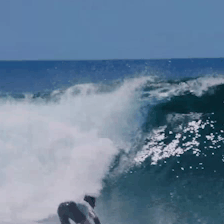

In [ ]:
video_tensor = sample_video
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [21]:
model_ckpt.split("/")[-1]
model_ckpt

'MCG-NJU/videomae-base'

In [22]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-2"
num_epochs = 4
batch_size = 16


args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

In [23]:
import evaluate

metric = evaluate.load("accuracy")

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [24]:
import torch


def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [25]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

KeyboardInterrupt: 

In [ ]:
train_results = trainer.train()

  0%|          | 0/54 [00:00<?, ?it/s]

In [ ]:
trainer.evaluate(train_dataset)

{'eval_loss': 0.5308454632759094,
 'eval_accuracy': 0.7181208053691275,
 'eval_runtime': 521.2289,
 'eval_samples_per_second': 0.286,
 'eval_steps_per_second': 0.073,
 'epoch': 3.22972972972973}

In [ ]:
trainer.evaluate(test_dataset)

c:\Users\antoi\Documents\Work_Learn\JEDHA\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'eval_loss': 0.6255781054496765,
 'eval_accuracy': 0.6956521739130435,
 'eval_runtime': 189.5334,
 'eval_samples_per_second': 0.364,
 'eval_steps_per_second': 0.095,
 'epoch': 3.22972972972973}

In [ ]:
trainer.evaluate(val_dataset)

c:\Users\antoi\Documents\Work_Learn\JEDHA\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'eval_loss': 0.6094832420349121,
 'eval_accuracy': 0.6727272727272727,
 'eval_runtime': 190.7382,
 'eval_samples_per_second': 0.288,
 'eval_steps_per_second': 0.073,
 'epoch': 3.22972972972973}

In [ ]:
train_results

In [ ]:
train_loss = train_results.training_loss

val_results = trainer.evaluate(eval_dataset=val_dataset)
val_loss = val_results['eval_loss']

# Calculate the ratio
loss_ratio = val_loss / train_loss

# Print the ratio
print("Validation Loss / Training Loss Ratio:", loss_ratio)


Validation Loss / Training Loss Ratio: 0.9164533593747479


In [ ]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

model.safetensors:   0%|          | 0.00/345M [00:00<?, ?B/s]

c:\Users\antoi\Documents\Work_Learn\JEDHA\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


***** test metrics *****
  epoch                   =     3.2297
  eval_accuracy           =     0.6957
  eval_loss               =     0.6256
  eval_runtime            = 0:03:57.06
  eval_samples_per_second =      0.291
  eval_steps_per_second   =      0.076


In [ ]:
# trainer.push_to_hub()

In [ ]:
trained_model = VideoMAEForVideoClassification.from_pretrained(new_model_name)

In [ ]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)

video torch.Size([3, 16, 224, 224])
video_name video_9.mp4
video_index 27
clip_index 0
aug_index 0
label 0
Video label: carve-frontside


c:\Users\antoi\Documents\Work_Learn\JEDHA\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.

    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

logits = run_inference(trained_model, sample_test_video["video"])

In [ ]:
display_gif(sample_test_video["video"])

NameError: name 'display_gif' is not defined

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: carve-frontside


In [ ]:
print(model.config.id2label)

{0: 'carve-frontside', 1: 'roller'}
